In [ ]:
#import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
# Any results you write to the current directory are saved as output.
import pandas as pd
import torch
import torchvision
from torchvision import transforms, datasets
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

In [ ]:
# train / test 데이터 만들기

test = pd.read_csv("../input/Kannada-MNIST/Dig-MNIST.csv")
train = pd.read_csv("../input/Kannada-MNIST/train.csv")
submission_set = pd.read_csv("../input/Kannada-MNIST/test.csv").iloc[:,1:]

train_data = train.drop('label', axis=1)
train_targets = train['label']


test_images= test.drop('label',axis=1)
test_labels= test['label']

# Train Test 분할
train_images, val_images, train_labels, val_labels = train_test_split(train_data, train_targets,
                                                                     test_size=0.2)

#인덱스 초기화
train_images.reset_index(drop=True, inplace=True)
train_labels.reset_index(drop=True, inplace=True)

val_images.reset_index(drop=True, inplace=True)
val_labels.reset_index(drop=True, inplace=True)

test_images.reset_index(drop=True, inplace=True)
test_labels.reset_index(drop=True, inplace=True)

print('Train Set')
print(train_images.shape)
print(train_labels.shape)

print('Validation Set')
print(val_images.shape)
print(val_labels.shape)

print('Validation 2')
print(test_images.shape)
print(test_labels.shape)

print('Submission')
print(submission_set.shape)

In [ ]:
print('Look at image means')
print(train_images.mean(axis=1).mean())
print(val_images.mean(axis=1).mean())
print(test_images.mean(axis=1).mean())
print(submission_set.mean(axis=1).mean())

In [ ]:
print('Train Distribution')
# 상대빈도수를 나타냄 (균일하게 나타나는 것을 알 수 있음)
print(train_labels.value_counts(normalize= True))
print('\nSubmission Distribution')
print(test_labels.value_counts(normalize=True))

In [ ]:
IMGSIZE = 28

# Transformations for train
train_trans = transforms.Compose(([
    transforms.ToPILImage(), # 이미지 형태로 변환
    transforms.RandomCrop(IMGSIZE), #random location에서 plt이미지를 잘라냄
    transforms.RandomAffine(degrees=5, translate=(0.1,0.1)), 
    #이미지의 중간은 변하지 않게 하고 Random affine // affine은 순전파에서 수행하는 행렬의 곱 (X*W+b)
    #degree : 선택할 범위 (min,max) / translate :랜덤 표본의 가로, 세로 absolute fraction의 최댓값
    # ex) (a,b) =>  range -img_width * a < dx < img_width * a
    
    transforms.ToTensor(), # plt image나 ndarry를 tensor로 변환 
    #transforms.Normalize((0.5,),(0.5,)) # (평균,분산) 으로 정규화 input[channel] = (input[channel] - mean[channel]) / std[channel]
]))

# validation과 teset 셋을 위한 변환 // 검사하는 set이기때문에 랜덤추출은 없음
val_trans= transforms.Compose(([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    #transforms.Normalize((0.1307,),(0.3081,))
]))
class KannadaDataSet(torch.utils.data.Dataset): # datasat을 변형시켜주는 함수
    def __init__(self, images, labels,transforms = None):
        self.X = images
        self.y = labels
        self.transforms = transforms
         
    def __len__(self):
        return (len(self.X))
    
    def __getitem__(self, i):
        data = self.X.iloc[i,:] #image의 i행의 데이터를 받음
        data = np.array(data).astype(np.uint8).reshape(IMGSIZE,IMGSIZE,1) #unit8타입의 (28,28,1)의 형태로 (신경망처리위해)
        
        if self.transforms: #transform에 값이 있으면 data를 변형시킴
            data = self.transforms(data)
            
        if self.y is not None: # 라벨이 있으면 i번째 데이터(변형됨), i번쨰 라벨을 튜플형태로 출력
            return (data, self.y[i])
        else:
            return data

In [ ]:
batch_size =128
#데이터 변환
train_data = KannadaDataSet(train_images, train_labels, train_trans)
val_data = KannadaDataSet(val_images, val_labels, val_trans)
test_data = KannadaDataSet(test_images, test_labels, val_trans)
submission_data = KannadaDataSet(submission_set, None, val_trans)

train_loader = torch.utils.data.DataLoader(train_data, #데이터셋
                                          batch_size = batch_size, # batch_size지정
                                          shuffle=True) #섞을 것인지

val_loader = torch.utils.data.DataLoader(val_data,
                                          batch_size = batch_size,
                                          shuffle=True)


test_loader = torch.utils.data.DataLoader(test_data,
                                          batch_size = batch_size,
                                          shuffle=True)

submission_loader = torch.utils.data.DataLoader(submission_data,
                                          batch_size = batch_size,
                                          shuffle=True)


classes = {'0','1','2','3','4','5','6','7','8','9'} # class의 라벨들



## Batch Normalization
### Gradient Vanishing/ Gradient Exploding일어나지 않도록 함
과거에는 Activation 함수, Initialization설정, 적은 학습률로 해결
#### 발생하는 이유는 Internal Covariance Shift때문
Network의 각 층이나 Activation마다 input의 분산이 달라지는 현상.  
이를 막기 위해 N(0,1)인 input으로 normalization => whitening방법 사용  
(but 공분산, 역행렬 계산량 ^ / 일부 parameter영향   
https://shuuki4.wordpress.com/2016/01/13/batch-normalization-%EC%84%A4%EB%AA%85-%EB%B0%8F-%EA%B5%AC%ED%98%84/

1. ## nn.MaxPool2d(kernel_size=(a,b))

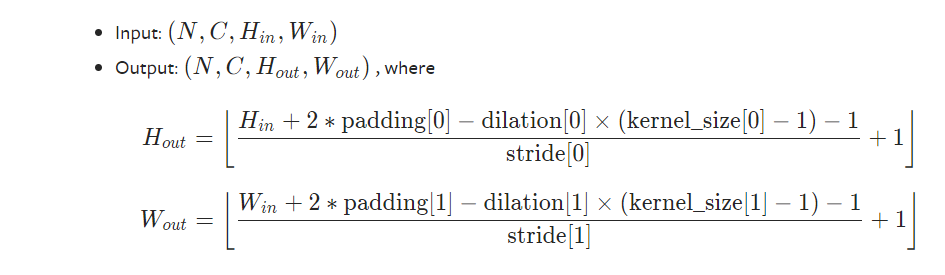

In [ ]:
class Net(nn.Module):
    def __init__(self, dropout = 0.40) :
        super(Net, self).__init__() # 자식클래스에서 부모클래스의 내용 사용
        self.dropout = dropout
        
        #x의 배치모양은 (1,28,28) #(배치, 채널의수, 높이, 너비)
        # 인풋 채널 =1, 아웃풋 채널 =18
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=5, stride=1, padding=2)
        #in_ch , out_ch, kernel_s 는 필수요소 / kernel_size = filter와 동일
        self.conv1_bn = nn.BatchNorm2d(num_features=64)
        # 4D의 배치 정규화에 사용 (N,C,H,W)
        # cf) BatchNorm1d = 2D(N,C) or 3D(N,C,L) input / BatchNorm3d 5D(N,C,D,H,W)
        self.conv1_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, stride=1, padding=2)
        self.conv1_1_bn = nn.BatchNorm2d(num_features=64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.d2_1 = nn.Dropout2d(p=self.dropout)
        
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.conv2_bn = nn.BatchNorm2d(num_features=128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.d2_2 = nn.Dropout2d(p=self.dropout)
        
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.conv3_bn = nn.BatchNorm2d(num_features=256)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.d2_3 = nn.Dropout2d(p=self.dropout)

        #4608 input 피쳐들, 256개의 output feature(sizing flow를 봐라)
        self.fc1 = nn.Linear(256 *3 *3,512) # Linear 1
        # 선형변환을 실시
        self.d1_1 = nn.Dropout(p=self.dropout)
        # 64개의 input feature, 10개의의 정의된 클래스를 위한 10개의 아웃풋 피쳐
        self.fc2 = nn.Linear(in_features=512, out_features=256) # linear 2
        self.d1_2 = nn.Dropout(p=self.dropout)
        self.fc3 = nn.Linear(in_features=256, out_features=128) # linear 3
        self.d1_3 = nn.Dropout(p=self.dropout)
        self.out = nn.Linear(in_features=128, out_features=10) # linear 3
        
        
    def forward(self,x):
        #첫번쨰 convolution의 activation을 계산
        #Size 를 (1,28,28)에서 (18,28,28)로 변경
        x = self.conv1(x)
        x = self.conv1_bn(x)
        x = F.relu(x)
        x = self.conv1_1(x)
        x = self.conv1_1_bn(x)
        x = F.relu(x)     
        
        x = self.d2_1(x)
        x = self.pool1(x) # Size를 (18,28,28) 에서 (18,14,14)로
        
        # 두번째 변환
        x = self.conv2(x)
        x = self.conv2_bn(x)
        x = F.relu(x)
        x = self.d2_2(x)
        x = self.pool2(x)  # Size를 (18,14,14)에서 (18,7,7)로
        
        # 세번째 변환
        x = self.conv3(x)
        x = self.conv3_bn(x)
        x = F.relu(x)
        x = self.d2_3(x)
        x = self.pool3(x) # Size를 (18,7,7)에서 (18,3,3)로
        
        #데이터를 신경망의 레이어의 input에 넣기 위해 Reshape
        #Size가 (18,14,14)에서 (1,3528)로
        # -1를 부르는 것은 현재 차원에서 주어진 다른 차원으로 바꾸는 것
        x = x.view(-1, 256 * 3 * 3)
        
        #첫번째 완전히 연결된 layer를 계산
        #Size가 (1,4608)에서 (1,64)로
        #첫번째 완전히 연결된 layer를 계산(activation은 나중에 적용됨)
        #Size가 (1,64)에서 (1,10)
        x = F.relu(self.fc1(x))
        x = self.d1_1(x)
        
        x = F.relu(self.fc2(x))
        x = self.d1_2(x)
        
        x = F.relu(self.fc3(x))
        x = self.d1_3(x)
        
        x = self.out(x)
        return F.log_softmax(x, dim=-1)

net = Net().to(device)
net

## 출력값
### 입력크기: (H,W), 필터크기: (FH,FW), 출력크기: (OH,OW), 패딩: P,스트라이드: S
OH = (H + 2P - FH)/S + 1    
OW = (W + 2P - FW)/S + 1

## 풀링
특징 :  
학습해야 할 매개변수가 없음  
채널 수가 변하지 않음(w,h 는 변함)  
입력의 변화에 영향 적음  
이미지에서는 보통 최대폴링 사용

In [ ]:
#밑바닥 딥러닝에 나온 공식
def outputSize(in_size, kernel_size, stride, padding):
    output = int((in_size - kernel_size + 2 * (padding)) / stride) + 1
    return(output)
#outputSize(64,5,1,2)

In [ ]:
# Learning Rate Finder https://sgugger.github.io/how-do-you-find-a-good-learning-rate.html

def find_lr(trn_loader, init_value = 1e-8, final_value=10., beta = 0.98):
    num = len(trn_loader)-1
    mult = (final_value / init_value) ** (1/num)
    lr = init_value
    optimizer.param_groups[0]['lr'] = lr
    avg_loss = 0.
    best_loss = 0.
    batch_num = 0
    losses = []
    log_lrs = []
    for data in trn_loader:
        batch_num += 1
        # 이전처럼 mini batch의 input/output을 위해 loss를 얻음
        inputs = data[0].to(device)
        labels = data[1].to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        # smooth loss를 계산
        avg_loss = beta * avg_loss + (1-beta)*loss.item()
        smoothed_loss = avg_loss / (1 - beta**batch_num)
        #loss가 exploding이면 멈춤
        if batch_num > 1 and smoothed_loss > 4 * best_loss:
            return log_lrs, losses
        #best loss를 기록
        if smoothed_loss < best_loss or batch_num==1:
            best_loss = smoothed_loss
        # 값을 저장
        losses.append(smoothed_loss)
        log_lrs.append(math.log10(lr))
        # SGD 단계 실시
        loss.backward()
        optimizer.step()
        # lr를 다음 단계를 위해 업데이트
        lr *= mult
        optimizer.param_groups[0]['lr'] = lr
    return log_lrs, losses

CrossEntropyLoss(
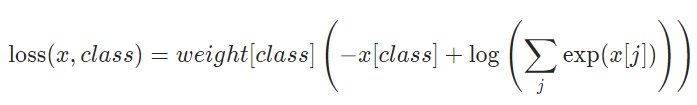

In [ ]:
net = Net().to(device)

#Loss Function(손실함수)
criterion = nn.CrossEntropyLoss()
# criterion = F.nll_loss

#Gradient Descent
#optimizer = optim.SGD(net.parameters(),lr=1e-1)
optimizer = optim.Adam(net.parameters(),lr=1e-1)

logs ,losses = find_lr(trn_loader = train_loader)
#plt.plot(logs[10:-5],losses[10:-5])

## tensor.item()의 의미
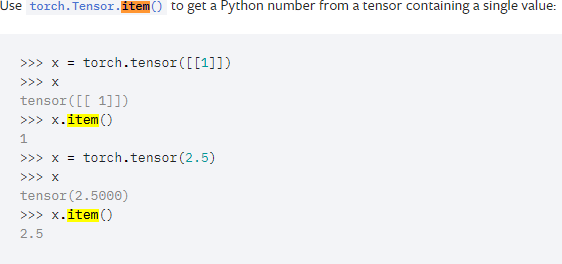

In [ ]:
net = Net().to(device)

EPOCHS = 1
nn_output = []

#optimizer = optim.SGD(net.parameters(),lr=1e-2)
optimizer = optim.Adam(net.parameters(),lr = 4e-3)
criterion = nn.CrossEntropyLoss()
#criterion = F.nll_loss

def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()
    # y축의 최댓값의 인덱스 값을 얻고 label의 값과 같으면 합한후 int값으로 

for epoch in range(EPOCHS):
    epoch_loss = 0
    epoch_correct = 0
    net.train()
    
    for data in train_loader:
        # 데이터는 데이터의 하나의 batch
        # 변환을 사용하기전에 빈 숫자 채널 배열(B 배치, C 채널수, H 높이, W 너비)
        #을 넣기위해 .unsqeeze(1)을 사용
        X = data[0].to(device) # X는 feature들의 batch
        # unsqueeze는 색상채널을 위한 placeholder dimension을 추가함 
        # -(8, 28, 28) to (8,1,28,28)
        y = data[1].to(device) # y는 타겟의 batch
        
        net.zero_grad() # loss 계산 전에 gradients를 설정. 너는 모든 단계에서 사용할것임
        output = net(X) # repashed batch를 통과시킴 (28x28 atm임을 떠올려라)
        tloss = criterion(output,y) # loss값을 계산하고 저장
        tloss.backward() # 네트워크의 파라미더에 loss backwards를 적용
        optimizer.step() # loss/gradients를 계산하기 위해 weight를 최적화
        
        epoch_loss += tloss.item() # epoch_loss에 tloss 값들을 계속 더함
        epoch_correct += get_num_correct(output,y)
        
    # validation set으로 평가
    net.eval() # self.train(False)와 같음, Sets the module in evaluation mode.??
    val_loss = 0
    val_correct = 0
    test_loss = 0
    test_correct = 0
    
    with torch.no_grad():
        # 첫번째 validation set
        for data in val_loader:
            X = data[0].to(device)
            y = data[1].to(device)
            
            preds= net(X) # predctions를 얻음
            vloss = criterion(preds, y) # loss를 계산
            
            val_correct += get_num_correct(preds, y)
            val_loss += vloss.item()
            
        #두번째 validation Set
        for data in test_loader:
            X = data[0].to(device)
            y = data[1].to(device)
            
            preds= net(X) # predctions를 얻음
            tloss = criterion(preds, y) # loss를 계산
            
            test_correct += get_num_correct(preds, y)
            test_loss += vloss.item()
            
    tmp_nn_output = [epoch + 1,EPOCHS,
                     epoch_loss/len(train_loader.dataset), epoch_correct/len(train_loader.dataset)*100,
                     val_loss/len(val_loader.dataset), val_correct/len(val_loader.dataset)*100,
                     test_loss/len(test_loader.dataset), test_correct/len(test_loader.dataset)*100
                    ]
    nn_output.append(tmp_nn_output)
    
    # validation set의 loss와 accuracy 인쇄
    print('Epoch [ {}/{} train loss:{:.6f} acc: {:.3f}  \
          valid loss: {:.6f} acc: {:.3f} \
          Test loss : {:.6f} acc: {:.3f}]'.format(*tmp_nn_output))
         

In [ ]:
vloss.type()

In [ ]:
pd_results = pd.DataFrame(nn_output,
    columns = ['epoch','total_epochs','train_loss','train_acc','valid_loss','valid_acc','test_loss','test_acc']
                         )
display(pd_results)

print("Best Epoch: {}".format(pd_results.loc[pd_results.valid_acc.idxmax()]['epoch']))
# pd_result의 valid_acc 컬럼에서 max값을 가지는 인덱스를 loc[]안에 입력, pd_result에서 epoch 컬럼 선택

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
axes[0].plot(pd_results['epoch'],pd_results['valid_loss'], label='validation_loss')
axes[0].plot(pd_results['epoch'],pd_results['train_loss'], label='train_loss')
#axes[0].plot(pd_results['epoch'],pd_results['test_loss'], label='test_loss')
axes[0].legend()

axes[1].plot(pd_results['epoch'],pd_results['valid_loss'], label='validation_loss')
axes[1].plot(pd_results['epoch'],pd_results['train_loss'], label='train_loss')
#axes[1].plot(pd_results['epoch'],pd_results['test_loss'], label='test_loss')
axes[1].legend()

In [ ]:
# torch.cat()
a = torch.ones(3,3)
b = torch.zeros(3,3)
c = torch.ones(3,3)+2
print(torch.cat([a,b,c],dim=0)) # 행결합
print(torch.cat([a,b,c],dim=1)) # 열결합

In [ ]:
num_classes = len(classes)

# Validation set을 confusion matrix를 만들 때 사용
net.eval() # 좋은 습관
predictions = torch.LongTensor().to(device) # 모든 예측을 위한 tensor

# val set을 goes through
for images, _ in val_loader:
    images = images.to(device)
    preds = net(images)
    predictions = torch.cat((predictions, preds.argmax(dim=1)), dim=0)
    # 주어진 차원의 tensor들의 sequnce를 합침. 모든 tensor는 같은 형태나 empty
    
# confusion matrix 만들기
cmt = torch.zeros(num_classes, num_classes, dtype=torch.int32)
for i in range(len(val_labels)):
    cmt[val_labels[i], predictions[i]] += 1

In [ ]:
cmt

In [ ]:
# test set에 신경망의 예측값을 얻을시간!
# test set을 DataLoader에 넣어라
net.eval() # safety first
predictions = torch.LongTensor().to(device) # 모든 예측을 위한 Tensor

# test set을 거침, 
for images in submission_loader:
    images = images.to(device)
    preds= net(images)
    predictions= torch.cat((predictions, preds.argmax(dim=1)),dim=0)